In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [27]:
#Some of this code is from Gregory Gundersen's pCCA repo.

inv = np.linalg.inv

class ProbabilisticCCA:
    def __init__(self, n_components, n_iters, reg=1e-6):
        """Initialize probabilistic CCA model."""
        self.k = n_components
        self.n_iters = n_iters
        self.reg = reg  # Regularization parameter

    def fit(self, X1, X2):
        """Fit model via EM."""
        self._init_params(X1, X2)
        
        for _ in range(self.n_iters):
            self._em_step()
            
            # Add regularization to ensure PSD
            self.Psi += self.reg * np.eye(self.Psi.shape[0])

    def transform(self, X1, X2):
        """Embed data using fitted model."""
        X = np.hstack([X1, X2]).T
        
        # Add regularization to Psi
        Psi_reg = self.Psi + self.reg * np.eye(self.Psi.shape[0])
        Psi_inv = inv(Psi_reg)
        
        M = inv(np.eye(self.k) + self.W.T @ Psi_inv @ self.W)
        Z = M @ self.W.T @ Psi_inv @ X
        return Z.T

    def fit_transform(self, X1, X2):
        """Fit and transform in one step."""
        self.fit(X1, X2)
        return self.transform(X1, X2)

    def sample(self, n_samples):
        """Sample from the fitted model."""
        # Add regularization to Psi
        Psi_reg = self.Psi + self.reg * np.eye(self.Psi.shape[0])
        Psi_inv = inv(Psi_reg)
        
        M = inv(np.eye(self.k) + self.W.T @ Psi_inv @ self.W)
        Z_post_mean = M @ self.W.T @ Psi_inv @ self.X
        X_mean = self.W @ Z_post_mean
        
        X = np.zeros((n_samples, self.p))
        for i in range(n_samples):
            # Use regularized Psi for sampling
            X[i] = np.random.multivariate_normal(X_mean[:, i], Psi_reg)
        
        return X[:, :self.p1], X[:, self.p1:]

    def _em_step(self):
        """Perform EM on parameters W and Psi"""
        # Add regularization to Psi
        Psi_reg = self.Psi + self.reg * np.eye(self.Psi.shape[0])
        Psi_inv = inv(Psi_reg)
        
        M = inv(np.eye(self.k) + self.W.T @ Psi_inv @ self.W)
        S = M @ self.W.T @ Psi_inv @ self.X
        A = self.n * M + S @ S.T
        
        # Regularize matrix inversion
        W_new = self.X @ S.T @ inv(A + self.reg * np.eye(A.shape[0]))
        
        W1 = self.W[:self.p1]
        W1_new = W_new[:self.p1]
        Psi1_inv = Psi_inv[:self.p1, :self.p1]
        Psi1_new = self.Sigma1 - self.Sigma1 @ Psi1_inv @ W1 @ M @ W1_new.T
        
        W2 = self.W[self.p1:]
        W2_new = W_new[self.p1:]
        Psi2_inv = Psi_inv[self.p1:, self.p1:]
        Psi2_new = self.Sigma2 - self.Sigma2 @ Psi2_inv @ W2 @ M @ W2_new.T
        
        Psi_new = np.block([[Psi1_new, np.zeros((self.p1, self.p2))],
                             [np.zeros((self.p2, self.p1)), Psi2_new]])
        
        self.W = W_new
        self.Psi = Psi_new

    def _init_params(self, X1, X2):
        """Initialize parameters."""
        self.X1, self.X2 = X1, X2
        self.n, self.p1 = self.X1.shape
        _, self.p2 = self.X2.shape
        self.p = self.p1 + self.p2
        
        # Initialize sample covariances matrices
        self.X = np.hstack([X1, X2]).T
        
        # Add small regularization to covariance matrices
        self.Sigma1 = np.cov(self.X1.T) + self.reg * np.eye(self.p1)
        self.Sigma2 = np.cov(self.X2.T) + self.reg * np.eye(self.p2)
        
        # Initialize W with SVD
        X_combined = np.hstack([X1, X2])
        U, _, _ = np.linalg.svd(X_combined, full_matrices=False)
        self.W = U[:, :self.k]
        
        # Initialize Psi with regularization
        prior_var1 = 1
        prior_var2 = 1
        Psi1 = (prior_var1 + self.reg) * np.eye(self.p1)
        Psi2 = (prior_var2 + self.reg) * np.eye(self.p2)
        Psi = np.block([[Psi1, np.zeros((self.p1, self.p2))],
                        [np.zeros((self.p2, self.p1)), Psi2]])
        self.Psi = Psi


In [28]:
# Set dimensions
K1 = 500  # Number of observations for Group 1
K2 = 500  # Number of observations for Group 2 (now equal to K1)
T = 250   # Number of time points
t = np.linspace(0, 2, T)  # Time intervals

# Latent dimensions
d_s = 1   # Shared latent dimension
d_1 = 2   # Independent latent dimension for group 1
d_2 = 2   # Independent latent dimension for group 2 (reduced to match group 1)

# Hyperparameters
rho = 1.0  # Scale for GP kernel
l = 2.0    # Length scale for GP kernel
nu = 0.1   # Noise variance for observations

# Kernel function
def rbf_kernel(t1, t2, rho=1.0, l=2.0):
    """RBF (Gaussian) kernel for GP"""
    return rho * np.exp(-0.5 * ((t1[:, np.newaxis] - t2[np.newaxis, :]) / l)**2)

# Generate GP trajectories
def generate_gp_trajectories(t, d, K, kernel_func, nu=0.1):
    """Generate GP trajectories for latent factors"""
    K_tt = kernel_func(t, t)
    L = np.linalg.cholesky(K_tt + nu * np.eye(len(t)))
    
    trajectories = np.zeros((K, len(t)))
    for k in range(K):
        z = np.random.randn(len(t))
        trajectories[k] = L @ z
    
    return trajectories

# Generate latent trajectories
Z_shared = generate_gp_trajectories(t, d_s, K1, rbf_kernel)
Z_1 = generate_gp_trajectories(t, d_1, K1, rbf_kernel)
Z_2 = generate_gp_trajectories(t, d_2, K1, rbf_kernel)

# Factor loadings
A_1 = np.random.randn(K1, d_1)
A_2 = np.random.randn(K1, d_2)
A_s1 = np.random.randn(K1, d_s)
A_s2 = np.random.randn(K1, d_s)

# Generate observations
X1 = np.zeros((K1, T))
X2 = np.zeros((K1, T))

# Generate observations for Group 1
for i in range(K1):
    shared_contrib = A_s1[i:i+1, :] @ Z_shared[:d_s, :]
    indep_contrib = A_1[i:i+1, :] @ Z_1[:d_1, :]
    X1[i] = (shared_contrib + indep_contrib).flatten()

# Generate observations for Group 2
for i in range(K1):
    shared_contrib = A_s2[i:i+1, :] @ Z_shared[:d_s, :]
    indep_contrib = A_2[i:i+1, :] @ Z_2[:d_2, :]
    X2[i] = (shared_contrib + indep_contrib).flatten()

# Add observation noise
X1 += np.random.normal(0, np.sqrt(nu), X1.shape)
X2 += np.random.normal(0, np.sqrt(nu), X2.shape)

# Print shapes to verify
print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)

X1 shape: (500, 250)
X2 shape: (500, 250)


/var/folders/ch/hyjw6whx3g9gshnp58738jc80000gp/T/ipykernel_6908/1681497525.py:52: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  X[i] = np.random.multivariate_normal(X_mean[:, i], Psi_reg)


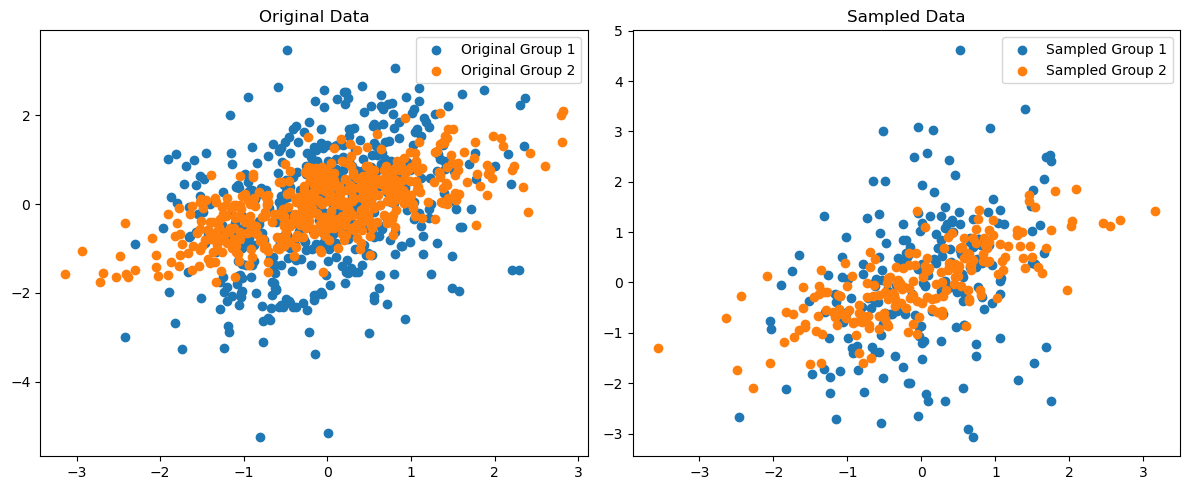

In [29]:
pcca = ProbabilisticCCA(n_components=2, n_iters=100)
pcca.fit(X1, X2)
X1_, X2_ = pcca.sample(200)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.scatter(X1[:, 0], X1[:, 1], label='Original Group 1')
ax1.scatter(X2[:, 0], X2[:, 1], label='Original Group 2')
ax1.set_title('Original Data')
ax1.legend()

ax2.scatter(X1_[:, 0], X1_[:, 1], label='Sampled Group 1')
ax2.scatter(X2_[:, 0], X2_[:, 1], label='Sampled Group 2')
ax2.set_title('Sampled Data')
ax2.legend()

plt.tight_layout()
plt.show()